In [2]:
!pwd

/groups/gaf51265/fumiyau/pivqa/notebooks


# Analysis of Estimation Error for Cumulative Question Answers

In [ ]:
import json
with open("../data/pivqa/questions/train/train.json") as f:
    vqas = json.load(f)
vqas[:10]

In [49]:
vqas[0].keys()

dict_keys(['questions', 'scene_index', 'video_filename'])

In [50]:
vqas[0]["questions"][0].keys()

dict_keys(['question_id', 'question', 'question_type', 'question_subtype', 'program', 'square_error', 'answer'])

In [51]:
for scene in vqas:
    index = scene["scene_index"]
    for question in scene["questions"][:5]:
        if question["square_error"] is not None and question["square_error"] >= 10 and question["question_subtype"] == "elaborative":
            print("=" * 10)
            print(f"Index: {index}\nQuestion:\n{question['question']}\nAnswer:\n{question['answer']}\nError: {question['square_error']}")

    

Index: 1505
Question:
How much has the yellow rubber sphere moved between 0.0s and 4.8s? Please provide the vector components in three dimensions.
Answer:
There are no collisions related to the yellow rubber sphere in between 0.0s and 4.8s.
From 0.0s to 4.8s, the motion pattern continued with velocity vectors [2.0065, -1.0773, 0.0]. During this time, the yellow rubber sphere moves [9.6312, -5.17104, 0.0]
Therefore, the cumulative movement is [9.6312, -5.17104, 0.0] = [9.6312, -5.17104, 0.0].
Error: 10.0775727896
Index: 1941
Question:
How much has the cyan rubber sphere moved between 0.0s and 4.8s? Please provide the vector components in three dimensions.
Answer:
There are no collisions related to the cyan rubber sphere in between 0.0s and 4.8s.
From 0.0s to 4.8s, the motion pattern continued with velocity vectors [-2.2457, -0.4905, 0.0]. During this time, the cyan rubber sphere moves [-10.779359999999999, -2.3544, 0.0]
Therefore, the cumulative movement is [-10.779359999999999, -2.3544

In [52]:
miss_count = 0
total_count = 0
for scene in vqas:
    index = scene["scene_index"]
    for question in scene["questions"]:
        if question["square_error"] is not None:
            total_count += 1
            if question["square_error"] >= 10:
                miss_count += 1

print(miss_count/total_count)    

0.04793122493576352


In [53]:
import numpy as np

thresholds = np.arange(0, 50, 0.25)
error_rates = []

for th in thresholds:
    miss_count = 0
    total_count = 0
    for scene in vqas:
        index = scene["scene_index"]
        for question in scene["questions"]:
            if question["square_error"] is not None:
                total_count += 1
                if question["square_error"] >= th:
                    miss_count += 1

    error_rates.append(miss_count/total_count * 100) 

In [54]:
print(thresholds)
print(error_rates)

[ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75
  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75
 12.   12.25 12.5  12.75 13.   13.25 13.5  13.75 14.   14.25 14.5  14.75
 15.   15.25 15.5  15.75 16.   16.25 16.5  16.75 17.   17.25 17.5  17.75
 18.   18.25 18.5  18.75 19.   19.25 19.5  19.75 20.   20.25 20.5  20.75
 21.   21.25 21.5  21.75 22.   22.25 22.5  22.75 23.   23.25 23.5  23.75
 24.   24.25 24.5  24.75 25.   25.25 25.5  25.75 26.   26.25 26.5  26.75
 27.   27.25 27.5  27.75 28.   28.25 28.5  28.75 29.   29.25 29.5  29.75
 30.   30.25 30.5  30.75 31.   31.25 31.5  31.75 32.   32.25 32.5  32.75
 33.   33.25 33.5  33.75 34.   34.25 34.5  34.75 35.   35.25 35.5  35.75
 36.   36.25 36.5  36.75 37.   37.25 37.5  37.75 38.   38.25 38.5  38.75
 39.   39.25 39.5  39.75 40.   40.25 40.5  40.75 41

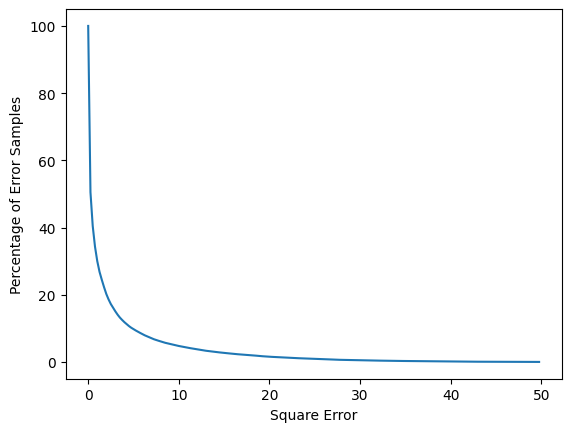

In [55]:
import matplotlib.pyplot as plt

plt.plot(thresholds, error_rates)
plt.xlabel("Square Error")
plt.ylabel("Percentage of Error Samples")
plt.show()

# Track of Question Generation

In [16]:
import json
import os
from tqdm import tqdm
import numpy as np
from typing import Tuple, List, Literal, Union
import random

from dataset.question import (
    LocationQuestion, 
    VelocityQuestion, 
    SimpleCumulativeQuestion, 
    ElaborativeCumulativeQuestion
    )
from dataset.annotation import ObjectProperty, Collision, Annotation
from constants import (
    CLEVRER_PATH, 
    PIVQA_DATASET_DIR,
    SEED, 
    FRAME_RATE, 
    NUM_QUESTIONS_PER_A_SCENE
    )

source_directory = "../"+CLEVRER_PATH
destination_directory = PIVQA_DATASET_DIR


def load_annotation()->Tuple[List[Annotation], List[Annotation]]:
    """
    returns train, valid set of annotations
    annotations contains an annotation of each frame.

    each annotation is a dictionary with the following keys:
        "scene_index": scene_index (e.g. 00300)
        "video_filename": video_filename (e.g. video_00300.mp4)
        "locations": (objects * frames * 3) np.array
        "velocities": (objects * frames * 3) np.array
    """
    train_annotations = []
    valid_annotaitons = []

    for root, dirs, files in os.walk(source_directory):
        dest_root = os.path.join(destination_directory, os.path.relpath(root, source_directory))

        if not "annotations" in dest_root:
            continue

        os.makedirs(dest_root, exist_ok=True)

        print(f"loading from {root}...")

        # read each annotation per a scene
        for file in tqdm(files):
            if file.endswith('.json'):

                source_file = os.path.join(root, file)

                with open(source_file, 'r') as f_source:
                    annotation_js = json.load(f_source)
                
                # load metadata
                scene_index = annotation_js["scene_index"]
                video_filename = annotation_js["video_filename"]

                num_objects = len(annotation_js["object_property"])
                num_frames = len(annotation_js["motion_trajectory"])

                # load object properties
                object_properties = []

                for prop in annotation_js["object_property"]:
                    object_id = prop["object_id"]
                    color = prop["color"]
                    material = prop["material"]
                    shape = prop["shape"]

                    object_properties.append(
                        ObjectProperty(
                            object_id, 
                            color, 
                            material, 
                            shape
                            )
                        )

                # load motions
                locations = np.zeros((num_objects, num_frames, 3))
                velocities = np.zeros((num_objects, num_frames, 3))

                for i in range(num_objects):
                    for j in range(num_frames):
                        locations[i, j] = annotation_js["motion_trajectory"][j]["objects"][i]["location"]
                        velocities[i, j] = annotation_js["motion_trajectory"][j]["objects"][i]["velocity"]

                assert isinstance(scene_index, int)

                # load collisions
                collisions:List[Collision] = []
                for c in annotation_js["collision"]:
                    collision = Collision(c["object_ids"], c["frame_id"], c["location"])
                    collisions.append(collision)
                
                # create single annotation
                annotation = Annotation(scene_index, video_filename, object_properties, locations, velocities, collisions)

                if "train" in root:
                    train_annotations.append(annotation)
                elif "valid" in root:
                    valid_annotaitons.append(annotation)

    train_annotations = sorted(train_annotations, key=lambda x: x.scene_index)
    valid_annotaitons = sorted(valid_annotaitons, key=lambda x: x.scene_index)

    return train_annotations, valid_annotaitons

In [17]:
_, valid_annotaitons = load_annotation()

loading from ../data/clevrer/annotations...


0it [00:00, ?it/s]


loading from ../data/clevrer/annotations/validation...


100%|██████████| 1/1 [00:00<00:00, 30174.85it/s]


loading from ../data/clevrer/annotations/validation/annotation_11000-12000...


100%|██████████| 1000/1000 [00:05<00:00, 195.32it/s]


loading from ../data/clevrer/annotations/validation/annotation_13000-14000...


100%|██████████| 1000/1000 [00:04<00:00, 200.15it/s]


loading from ../data/clevrer/annotations/validation/annotation_10000-11000...


100%|██████████| 1000/1000 [00:05<00:00, 192.68it/s]


loading from ../data/clevrer/annotations/validation/annotation_14000-15000...


100%|██████████| 1000/1000 [00:04<00:00, 202.54it/s]


loading from ../data/clevrer/annotations/validation/annotation_12000-13000...


100%|██████████| 1000/1000 [00:05<00:00, 190.78it/s]


loading from ../data/clevrer/annotations/train...


100%|██████████| 1/1 [00:00<00:00, 27235.74it/s]


loading from ../data/clevrer/annotations/train/annotation_01000-02000...


100%|██████████| 1000/1000 [00:05<00:00, 193.51it/s]


loading from ../data/clevrer/annotations/train/annotation_00000-01000...


100%|██████████| 1000/1000 [00:05<00:00, 191.83it/s]


loading from ../data/clevrer/annotations/train/annotation_07000-08000...


100%|██████████| 1000/1000 [00:05<00:00, 190.20it/s]


loading from ../data/clevrer/annotations/train/annotation_02000-03000...


100%|██████████| 1000/1000 [00:05<00:00, 191.57it/s]


loading from ../data/clevrer/annotations/train/annotation_08000-09000...


100%|██████████| 1000/1000 [00:05<00:00, 186.81it/s]


loading from ../data/clevrer/annotations/train/annotation_03000-04000...


100%|██████████| 1000/1000 [00:05<00:00, 194.74it/s]


loading from ../data/clevrer/annotations/train/annotation_05000-06000...


100%|██████████| 1000/1000 [00:05<00:00, 184.81it/s]


loading from ../data/clevrer/annotations/train/annotation_09000-10000...


100%|██████████| 1000/1000 [00:05<00:00, 190.28it/s]


loading from ../data/clevrer/annotations/train/annotation_04000-05000...


100%|██████████| 1000/1000 [00:05<00:00, 183.99it/s]


loading from ../data/clevrer/annotations/train/annotation_06000-07000...


100%|██████████| 1000/1000 [00:05<00:00, 187.48it/s]


In [18]:
vars(valid_annotaitons[3])

{'scene_index': 10003,
 'video_filename': 'video_10003.mp4',
 'object_properties': [ObjectProperty(object_id=0, color=yellow, material=metal, shape=cube),
  ObjectProperty(object_id=1, color=blue, material=metal, shape=sphere),
  ObjectProperty(object_id=2, color=yellow, material=rubber, shape=sphere),
  ObjectProperty(object_id=3, color=yellow, material=metal, shape=cylinder)],
 'locations': array([[[ 1.0558,  3.735 ,  0.2   ],
         [ 1.0245,  3.6597,  0.1998],
         [ 0.9934,  3.585 ,  0.1997],
         ...,
         [-0.2182,  1.3534,  0.201 ],
         [-0.2182,  1.3534,  0.201 ],
         [-0.2182,  1.3534,  0.201 ]],
 
        [[ 0.183 ,  1.4192,  0.1995],
         [ 0.183 ,  1.4192,  0.2001],
         [ 0.183 ,  1.4192,  0.2004],
         ...,
         [-0.5027, -0.9496,  0.2008],
         [-0.5097, -0.9616,  0.2008],
         [-0.5166, -0.9735,  0.2008]],
 
        [[-0.3437, -1.1165,  0.2008],
         [-0.3437, -1.1165,  0.2008],
         [-0.3437, -1.1165,  0.2008],
 

In [46]:

def export_qa(
        annotations:List[Annotation], 
        dataset_type:Literal["train", "validation"],
        num_questions_per_a_scene:int=NUM_QUESTIONS_PER_A_SCENE,
        )->None:
    """
    output: qa dataset (list of {questions, scene_index, video_filename})
    [{"questions", "scene_index", "video_filename"}, {}, ...]

    questions: list of dict {
        "question_id", 
        "question", 
        "question_type", 
        "question_subtype", 
        "program", 
        "answer"
        }
    """
    random.seed(SEED)

    qa_dataset = []
    for annotation in tqdm(annotations[:200]):
        questions = []

        # create {num_questions_per_a_scene} questions per a video
        for i in range(num_questions_per_a_scene):

            # choose template of a question
            question_cls = random.choice([
                ElaborativeCumulativeQuestion
                ])
            qa_generator = question_cls(annotation.locations, annotation.velocities)

            # choose objects and retrieve attributes 
            object_id = random.randint(0, annotation.locations.shape[0]-1)
            frame_id = random.randint(0, annotation.locations.shape[1]-1)

            color = annotation.object_properties[object_id].color
            material = annotation.object_properties[object_id].material
            shape = annotation.object_properties[object_id].shape

            square_error = None

            # generate QA text
            if isinstance(qa_generator, Union[LocationQuestion, VelocityQuestion]):
                question, answer = qa_generator.generate_qa(object_id, color, material, shape, frame_id)
            elif isinstance(qa_generator, Union[SimpleCumulativeQuestion, ElaborativeCumulativeQuestion]):
                interval = FRAME_RATE // 2
                start_frame_idx = random.randint(0, (annotation.locations.shape[1]-1-FRAME_RATE) // interval) * interval
                end_frame_idx = random.randint((start_frame_idx+FRAME_RATE) // interval, (annotation.locations.shape[1]-1) // interval) * interval
                related_collisions = [] 
                for c in annotation.collisions:
                    if (c.frame_id>=start_frame_idx and c.frame_id<end_frame_idx) and object_id in c.object_ids:
                        related_collisions.append(c)
                related_collisions = sorted(related_collisions, key=lambda x: x.frame_id)

                question, answer, square_error = qa_generator.generate_qa(
                    object_id, 
                    annotation.object_properties, 
                    related_collisions, 
                    color, 
                    material,
                    shape, 
                    start_frame_idx, 
                    end_frame_idx
                    )
                
                if square_error >= 5:
                    print("====")
                    print("scene_index:", annotation.scene_index)
                    print("object_id:", object_id)
                    print("time:", start_frame_idx/25, " - ", end_frame_idx/25)
                    print("related_collisions:", related_collisions)
                    print("prop:", color, material, shape)
                    print("square_error:", square_error)
                
            question_dict = {
                "question_id": i,
                "question": question,
                "question_type": qa_generator.question_type,
                "question_subtype": qa_generator.question_subtype,
                "program": [],
                "square_error": square_error,
                "answer": answer
            }
            questions.append(question_dict)

        scene_index = annotation.scene_index
        video_filename = annotation.video_filename

        qa_dataset.append({
            "questions": questions,
            "scene_index": scene_index,
            "video_filename": video_filename
        })
    return qa_dataset


In [47]:
qa_dataset = export_qa(valid_annotaitons, "validation")

 52%|█████▎    | 105/200 [00:00<00:00, 524.02it/s]

====
scene_index: 10002
object_id: 1
time: 0.0  -  4.8
related_collisions: [<dataset.annotation.Collision object at 0x147cb1323af0>, <dataset.annotation.Collision object at 0x147cb1323fd0>]
prop: gray metal sphere
square_error: 5.1129829113920024
====
scene_index: 10003
object_id: 3
time: 0.0  -  3.84
related_collisions: []
prop: yellow metal cylinder
square_error: 5.189754723679997
====
scene_index: 10007
object_id: 3
time: 0.0  -  4.32
related_collisions: []
prop: blue metal cube
square_error: 5.506077318687999
====
scene_index: 10009
object_id: 3
time: 0.0  -  4.8
related_collisions: [<dataset.annotation.Collision object at 0x147cb1500370>]
prop: red metal sphere
square_error: 7.279466080784005
====
scene_index: 10013
object_id: 2
time: 0.0  -  4.8
related_collisions: [<dataset.annotation.Collision object at 0x147cb177f880>]
prop: yellow rubber cube
square_error: 5.396844189199991
====
scene_index: 10020
object_id: 3
time: 0.0  -  3.84
related_collisions: []
prop: brown rubber spher

100%|██████████| 200/200 [00:00<00:00, 525.24it/s]

====
scene_index: 10117
object_id: 3
time: 0.0  -  4.8
related_collisions: []
prop: gray rubber cylinder
square_error: 5.928228793999992
====
scene_index: 10117
object_id: 2
time: 0.0  -  4.8
related_collisions: [<dataset.annotation.Collision object at 0x147cb17a2f20>]
prop: yellow rubber cylinder
square_error: 6.367412152799998
====
scene_index: 10119
object_id: 3
time: 0.48  -  4.32
related_collisions: []
prop: red rubber sphere
square_error: 6.4391282037279955
====
scene_index: 10119
object_id: 3
time: 0.0  -  4.8
related_collisions: []
prop: red rubber sphere
square_error: 9.822684603199999
====
scene_index: 10119
object_id: 2
time: 0.0  -  3.84
related_collisions: []
prop: cyan metal cylinder
square_error: 5.4863648067199975
====
scene_index: 10120
object_id: 3
time: 0.0  -  4.8
related_collisions: [<dataset.annotation.Collision object at 0x147cb167c310>]
prop: cyan metal sphere
square_error: 7.914134221327992
====
scene_index: 10121
object_id: 3
time: 0.0  -  4.32
related_collisi

In [56]:
qa_dataset

[{'questions': [{'question_id': 0,
    'question': 'How much has the brown metal cube moved between 1.44s and 2.88s? Please provide the vector components in three dimensions.',
    'question_type': 'cumulative',
    'question_subtype': 'elaborative',
    'program': [],
    'square_error': 0.04526386219200004,
    'answer': 'There are no collisions related to the brown metal cube in between 1.44s and 2.88s.\nFrom 1.44s to 2.88s, the motion pattern continued with velocity vectors [0.4565, -0.1799, -0.0111]. During this time, the brown metal cube moves [0.65736, -0.259056, -0.015984]\nTherefore, the cumulative movement is [0.65736, -0.259056, -0.015984] = [0.65736, -0.259056, -0.015984].'},
   {'question_id': 1,
    'question': 'How much has the brown metal cube moved between 2.88s and 3.84s? Please provide the vector components in three dimensions.',
    'question_type': 'cumulative',
    'question_subtype': 'elaborative',
    'program': [],
    'square_error': 0.004443600927999996,
    